In [1]:
# Standard library imports
from pathlib import Path

# Third party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm


## Exploratory data analysis

In [2]:
!ls /kaggle/input/fashionmnist

fashion-mnist_test.csv	 t10k-images-idx3-ubyte  train-images-idx3-ubyte
fashion-mnist_train.csv  t10k-labels-idx1-ubyte  train-labels-idx1-ubyte


In [3]:
train_data_csv = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")
train_data_csv.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
x = train_data_csv.loc[:, "pixel1":].values
x = torch.from_numpy(x).to(torch.float32)
x = x.view(60000, 1, 28, 28).contiguous()

y = train_data_csv.label.values
y = torch.from_numpy(y).to(torch.float32)

print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([60000, 1, 28, 28])
y shape: torch.Size([60000])


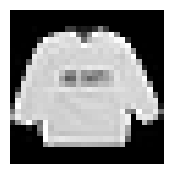

In [5]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.imshow(x[0].permute(1, 2, 0), cmap="gray")
ax.axis("off")
plt.show()

In [6]:
train_data_csv.label.value_counts().sort_index()

0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
Name: label, dtype: int64

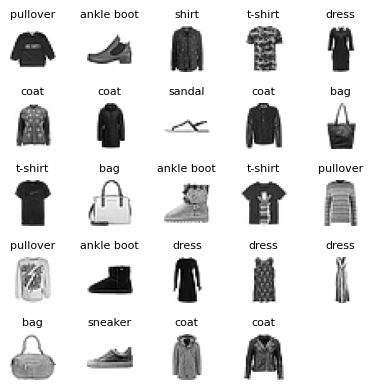

In [7]:
label_map = {
    0: "t-shirt",
    1: "trouser",
    2: "pullover",
    3: "dress",
    4: "coat",
    5: "sandal",
    6: "shirt",
    7: "sneaker",
    8: "bag",
    9: "ankle boot",
}

def show_imgs(imgs, labels, ncols=None, figsize=(4, 4)):
    if ncols:
        nrows = int(np.ceil(imgs.shape[0] / ncols))
    else:
        ncols = int(np.ceil(np.sqrt(imgs.shape[0])))
        nrows = ncols
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    for row in range(nrows):
        for col in range(ncols):
            img_idx = row * ncols + col
            if img_idx < imgs.shape[0]:
                ax[row][col].imshow(imgs[img_idx, ...].permute(1, 2, 0), cmap="gray_r")
                ax[row][col].set_title(labels[img_idx], fontsize=8)
            ax[row][col].axis("off")
    fig.tight_layout()
    return fig

imgs = x[:24]
labels = [label_map[label.item()] for label in y[:24]]

fig = show_imgs(imgs, labels)
plt.show()

## Splitting into training and validation datasets

In [8]:
x_train = x[:25000].clone()
y_train = y[:25000].clone()

x_val = x[25000:].clone()
y_val = y[25000:].clone()

In [9]:
for label, counts in zip(*y_train.unique(return_counts=True)):
    print(f"{label}:\t{counts}")

0.0:	2529
1.0:	2526
2.0:	2461
3.0:	2508
4.0:	2431
5.0:	2476
6.0:	2532
7.0:	2577
8.0:	2464
9.0:	2496


In [10]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class FashionMNISTData(Dataset):
    
    def __init__(self, imgs, labels, transforms_pipeline=None):
        self.imgs = imgs
        self.labels = labels
        self.transforms_pipeline=transforms_pipeline
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if self.transforms_pipeline is not None:
            return self.transforms_pipeline(self.imgs[idx]), self.labels[idx].to(torch.int64)
        else:
            return self.imgs[idx], self.labels[idx].to(torch.int64)

train_transforms = transforms.Compose([
    transforms.Normalize(x_train.mean(), x_train.std()),
    transforms.RandomHorizontalFlip(p=0.5),
])
val_transforms = transforms.Compose([
    transforms.Normalize(x_train.mean(), x_train.std()),
])

train_data = FashionMNISTData(x_train, y_train, transforms_pipeline=train_transforms)
val_data  = FashionMNISTData(x_val, y_val, transforms_pipeline=val_transforms)

## Benchmark model

## Resnet model from scratch

In [11]:
class ResnetBlock(nn.Module):
    
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 downsample=False,
                 kernel_size=3,
                 padding=1):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 
                               out_channels,
                               kernel_size=kernel_size,
                               stride=2 if downsample else 1,
                               padding=padding)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,
                               out_channels,
                               kernel_size=kernel_size,
                               stride=1,
                               padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(in_channels,
                               out_channels,
                               kernel_size=1,
                               stride=2 if downsample else 1,
                               padding=0)
        
    def forward(self, x):
        x_init = x.clone()
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(self.bn2(self.conv2(x)))
        if x_init.shape[1] != x.shape[1]:
            x_init = self.conv3(x_init)
        return F.relu(x + x_init)
        
            

class MiniResnet(nn.Module):
    
    def __init__(self, n_features):
        super().__init__()
        self.block1 = ResnetBlock(1, n_features)
        self.block2 = ResnetBlock(n_features, n_features)
        self.block3 = ResnetBlock(n_features, 2*n_features, downsample=True)
        self.block4 = ResnetBlock(2*n_features, 2*n_features)
        self.block5 = ResnetBlock(2*n_features, 4*n_features, downsample=True)
        self.block6 = ResnetBlock(4*n_features, 4*n_features)
        self.fully_connected = nn.Linear(4*n_features, 10)
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        return self.fully_connected(x.mean(dim=(2, 3)))
    
def init_weights(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

In [12]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2, stride=2, padding=1)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(6272, 100)
        self.fc2 = nn.Linear(100, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
        
        
        
test_model = SimpleCNN()
test_model(train_data[:64][0]).shape

torch.Size([64, 10])

In [13]:
model = MiniResnet(32)
model.apply(init_weights)

# model = SimpleCNN()
# model.apply(init_weights)

MiniResnet(
  (block1): ResnetBlock(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv3): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): ResnetBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (block3): ResnetBlock(
    (conv1)

In [14]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64
n_train_batches = len(train_data) // batch_size
n_val_batches = len(val_data) // batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)

def calc_acc_from_logits(inputs, targets):
    with torch.no_grad():
        preds = torch.argmax(torch.softmax(inputs, dim=0), dim=1)
        return torch.sum(preds == targets) / len(targets)

In [15]:
n_epochs = 250

model.to(device)
lr = 1.e-3
weight_decay = 1.e-4
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_func = nn.CrossEntropyLoss()

train_batch_losses = torch.zeros(n_train_batches, device=device)
train_batch_accuracies = torch.zeros(n_train_batches, device=device)
train_epoch_losses = torch.zeros(n_epochs, device=device)
train_epoch_accuracies = torch.zeros(n_epochs, device=device)

val_batch_losses = torch.zeros(n_val_batches, device=device)
val_batch_accuracies = torch.zeros(n_val_batches, device=device)
val_epoch_losses = torch.zeros(n_epochs, device=device)
val_epoch_accuracies = torch.zeros(n_epochs, device=device)

for i in tqdm(range(n_epochs)):
    model.train()
    for j, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        optim.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, targets)
        loss.backward()
        optim.step()
        
        train_batch_losses[j] = loss.item()
        train_batch_accuracies[j] = calc_acc_from_logits(outputs, targets)
    train_epoch_losses[i] = train_batch_losses.mean()
    train_epoch_accuracies[i] = train_batch_accuracies.mean()
    
    model.eval()
    with torch.no_grad():
        for k, (inputs, targets) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            val_batch_losses[k] = loss_func(outputs, targets).item()
            val_batch_accuracies[k] = calc_acc_from_logits(outputs, targets)
    val_epoch_losses[i] = val_batch_losses.mean()
    val_epoch_accuracies[i] = val_batch_accuracies.mean()
            

  0%|          | 0/250 [00:00<?, ?it/s]

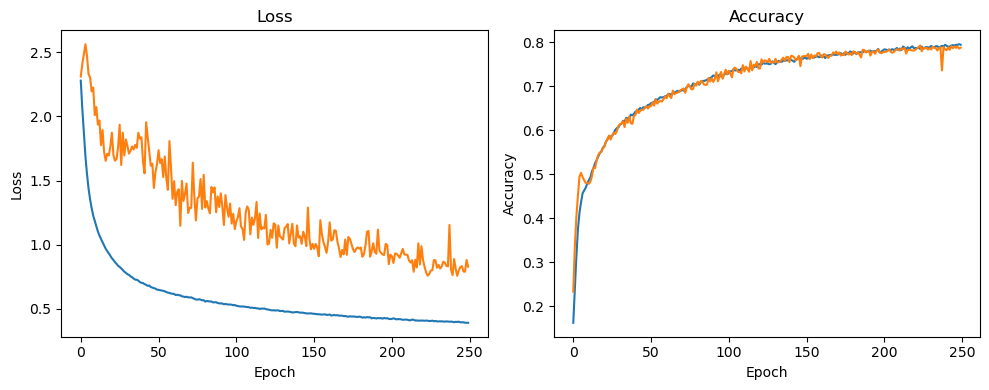

In [16]:
train_epoch_losses = train_epoch_losses.to("cpu")
val_epoch_losses = val_epoch_losses.to("cpu")
train_epoch_accuracies = train_epoch_accuracies.to("cpu")
val_epoch_accuracies = val_epoch_accuracies.to("cpu")


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
epoch = torch.arange(n_epochs)

ax[0].plot(epoch, train_epoch_losses, label="train")
ax[0].plot(epoch, val_epoch_losses)
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")

ax[1].plot(epoch, train_epoch_accuracies, label="train")
ax[1].plot(epoch, val_epoch_accuracies, label="validation")
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")

fig.tight_layout()
plt.show()

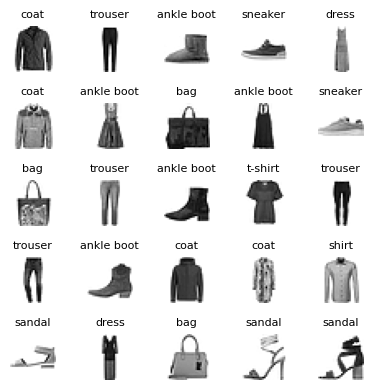

In [17]:
model.to("cpu")
imgs, labels = val_data[:25]
preds = model(imgs)
accuracy = calc_acc_from_logits(preds, labels)

preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
preds = [label_map[pred.item()] for pred in preds]

fig = show_imgs(imgs, preds)
plt.show()

In [18]:
accuracy

tensor(0.8400)